# Interactive Deterrence Playground

Use the sliders below to choose parameters and see how total system wealth evolves. Each configuration is averaged across multiple Monte Carlo runs (default: 10; adjustable via the “MC runs” slider) so the curves reflect policy rather than random noise. The chart updates automatically whenever you release a slider.

*Note: Nuclear weapons are not modeled yet—this focuses on conventional deterrence and bargaining.*


In [1]:
import importlib
import contextlib
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

import deterrence_simulation as ds

plt.style.use('seaborn-v0_8')



In [2]:
def run_simulation(
    num_countries: int,
    num_rounds: int,
    attack_cost: float,
    failed_attack_cost: float,
    defender_defense_loss: float,
    bargain_ev: float,
    nuke_prob: float,
    nuke_cost_mult: float,
    trials: int = 10,
    base_seed: int = 42,
):
    """Run multiple simulation trials and return averages for plotting."""
    original_params = {
        'NUM_COUNTRIES': ds.NUM_COUNTRIES,
        'ATTACK_COST_PERCENTAGE': ds.ATTACK_COST_PERCENTAGE,
        'FAILED_ATTACK_COST_PERCENTAGE': ds.FAILED_ATTACK_COST_PERCENTAGE,
        'ATTACK_SUCCESS_DISCOUNT_CAP': ds.ATTACK_SUCCESS_DISCOUNT_CAP,
        'DEFENDER_DEFENSE_LOSS_PERCENTAGE': ds.DEFENDER_DEFENSE_LOSS_PERCENTAGE,
        'BARGAIN_EV_PERCENTAGE': ds.BARGAIN_EV_PERCENTAGE,
        'NUKE_PROBABILITY': ds.NUKE_PROBABILITY,
        'NUKE_COST_MULTIPLIER': ds.NUKE_COST_MULTIPLIER,
    }

    ds.NUM_COUNTRIES = num_countries
    ds.ATTACK_COST_PERCENTAGE = attack_cost
    ds.FAILED_ATTACK_COST_PERCENTAGE = failed_attack_cost
    ds.DEFENDER_DEFENSE_LOSS_PERCENTAGE = defender_defense_loss
    ds.BARGAIN_EV_PERCENTAGE = bargain_ev
    ds.NUKE_PROBABILITY = nuke_prob
    ds.NUKE_COST_MULTIPLIER = nuke_cost_mult

    round_count = num_rounds + 1
    totals_matrix = np.zeros((trials, round_count))
    active_matrix = np.zeros((trials, round_count))
    bargains_matrix = np.zeros((trials, num_rounds))
    attacks_matrix = np.zeros((trials, num_rounds))

    # Track sample country trajectories and actions from first trial
    sample_country_values = None
    country_order = None
    sample_country_actions = {}
    sample_nuke_status = {}
    sample_sim = None

    try:
        for t in range(trials):
            seed = base_seed + t
            sim = ds.DeterrenceSimulation(num_countries=num_countries, seed=seed)
            totals_matrix[t, 0] = sim.get_total_value()
            active_matrix[t, 0] = sum(1 for c in sim.countries.values() if c.is_active)

            # Capture sample data from first trial
            if t == 0:
                sample_sim = sim
                country_order = list(sim.countries.keys())
                sample_country_values = np.zeros((round_count, len(country_order)))
                sample_country_values[0, :] = [sim.countries[cid].private_value for cid in country_order]
                for cid in country_order:
                    sample_country_actions[cid] = {'attacks': 0, 'bargains': 0}
                    sample_nuke_status[cid] = sim.countries[cid].has_nuke

            for round_idx in range(num_rounds):
                with contextlib.redirect_stdout(io.StringIO()):
                    results = sim.run_round()
                totals_matrix[t, round_idx + 1] = sim.get_total_value()
                active_matrix[t, round_idx + 1] = sum(1 for c in sim.countries.values() if c.is_active)
                bargains_matrix[t, round_idx] = sum(1 for r in results if r['outcome'] == 'bargain')
                attacks_matrix[t, round_idx] = sum(1 for r in results if r['outcome'] != 'bargain')

                # Track sample country values and actions from first trial
                if t == 0:
                    sample_country_values[round_idx + 1, :] = [sim.countries[cid].private_value if cid in sim.countries and sim.countries[cid].is_active else 0.0 for cid in country_order]
                    for r in results:
                        if r['outcome'] == 'bargain':
                            participants = [r.get('country1'), r.get('country2')]
                            for participant in participants:
                                if participant is None:
                                    continue
                                if participant not in sample_country_actions:
                                    sample_country_actions[participant] = {'attacks': 0, 'bargains': 0}
                                sample_country_actions[participant]['bargains'] += 1
                        else:
                            attacker = r.get('attacker')
                            if attacker is None:
                                continue
                            if attacker not in sample_country_actions:
                                sample_country_actions[attacker] = {'attacks': 0, 'bargains': 0}
                            sample_country_actions[attacker]['attacks'] += 1
    finally:
        ds.NUM_COUNTRIES = original_params['NUM_COUNTRIES']
        ds.ATTACK_COST_PERCENTAGE = original_params['ATTACK_COST_PERCENTAGE']
        ds.FAILED_ATTACK_COST_PERCENTAGE = original_params['FAILED_ATTACK_COST_PERCENTAGE']
        ds.ATTACK_SUCCESS_DISCOUNT_CAP = original_params['ATTACK_SUCCESS_DISCOUNT_CAP']
        ds.DEFENDER_DEFENSE_LOSS_PERCENTAGE = original_params['DEFENDER_DEFENSE_LOSS_PERCENTAGE']
        ds.BARGAIN_EV_PERCENTAGE = original_params['BARGAIN_EV_PERCENTAGE']
        ds.NUKE_PROBABILITY = original_params['NUKE_PROBABILITY']
        ds.NUKE_COST_MULTIPLIER = original_params['NUKE_COST_MULTIPLIER']

    rounds = list(range(round_count))
    avg_totals = totals_matrix.mean(axis=0)
    avg_active = active_matrix.mean(axis=0)
    avg_bargains = bargains_matrix.mean(axis=0)
    avg_attacks = attacks_matrix.mean(axis=0)

    pct_change = np.zeros_like(avg_totals)
    pct_change[1:] = np.where(
        avg_totals[:-1] > 0,
        (avg_totals[1:] - avg_totals[:-1]) / avg_totals[:-1] * 100,
        0,
    )

    return rounds, avg_totals, pct_change, avg_active, avg_bargains, avg_attacks, sample_country_values, country_order, sample_country_actions, sample_nuke_status



In [3]:
def plot_totals(num_countries, num_rounds, attack_cost, failed_attack_cost, defender_defense_loss, bargain_ev, nuke_prob, nuke_cost_mult, mc_trials):
    rounds, totals, pct_change, active_counts, bargains, attacks, country_traces, country_order, country_actions, nuke_status = run_simulation(
        num_countries=int(num_countries),
        num_rounds=int(num_rounds),
        attack_cost=attack_cost,
        failed_attack_cost=failed_attack_cost,
        defender_defense_loss=defender_defense_loss,
        bargain_ev=bargain_ev,
        nuke_prob=nuke_prob,
        nuke_cost_mult=nuke_cost_mult,
        trials=int(mc_trials),
    )

    fig, axes = plt.subplots(3, 1, figsize=(10, 13), sharex=True,
                             gridspec_kw={'height_ratios': [2, 1, 1]})
    ax_total, ax_pct, ax_active = axes

    ax_total.plot(rounds, totals, marker='o', linewidth=2, color='#004488')
    ax_total.set_ylabel('Average Total System Value', fontsize=12, fontweight='bold')
    ax_total.set_title(f'Total Wealth Over Time (averaged over {int(mc_trials)} runs)', fontsize=14, fontweight='bold')
    ax_total.grid(True, alpha=0.3)

    summary_lines = [f"Round {r}: {b:.1f} bargains / {a:.1f} attacks" for r, b, a in zip(rounds[1:], bargains, attacks)]
    annotation = "\n".join(summary_lines) if summary_lines else "No rounds run"
    ax_total.text(1.02, 0.5, annotation, transform=ax_total.transAxes, va='center', fontsize=10,
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax_pct.bar(rounds[1:], pct_change[1:], color='#E67E22', alpha=0.8)
    ax_pct.axhline(0, color='black', linewidth=1)
    ax_pct.set_ylabel('% Change vs Prev Round', fontsize=12, fontweight='bold')
    ax_pct.set_title('Percentage Change in Total Wealth', fontsize=12, fontweight='bold')
    ax_pct.grid(True, alpha=0.3)

    ax_active.plot(rounds, active_counts, marker='s', linewidth=2, color='#2E8B57')
    ax_active.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax_active.set_ylabel('Avg Active Countries', fontsize=12, fontweight='bold')
    ax_active.set_title('Average Countries Remaining', fontsize=12, fontweight='bold')
    ax_active.grid(True, alpha=0.3)
    ax_active.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

    if country_traces is not None and country_order is not None:
        rounds_range = list(range(country_traces.shape[0]))
        num_countries_to_plot = country_traces.shape[1]
        cmap = plt.get_cmap('tab20')

        fig2, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
        ax_log, ax_linear = axes

        for idx in range(num_countries_to_plot):
            line = country_traces[:, idx]
            nonpos = np.where(line <= 0)[0]
            if nonpos.size > 0:
                cutoff = nonpos[0]
                if cutoff == 0:
                    continue
                x_vals = rounds_range[:cutoff]
                y_vals = line[:cutoff]
            else:
                x_vals = rounds_range
                y_vals = line
            ax_log.plot(x_vals, y_vals, color=cmap(idx % 20), alpha=0.6, linewidth=1)
            ax_linear.plot(x_vals, y_vals, color=cmap(idx % 20), alpha=0.6, linewidth=1)

        ax_log.set_title('Sample Country Wealth (log scale)', fontsize=14, fontweight='bold')
        ax_log.set_xlabel('Round', fontsize=12, fontweight='bold')
        ax_log.set_ylabel('Private Value (log)', fontsize=12, fontweight='bold')
        ax_log.set_yscale('log')
        ax_log.set_ylim(1e-10, None)
        ax_log.grid(True, alpha=0.3, which='both')

        ax_linear.set_title('Sample Country Wealth (linear)', fontsize=14, fontweight='bold')
        ax_linear.set_xlabel('Round', fontsize=12, fontweight='bold')
        ax_linear.set_ylabel('Private Value', fontsize=12, fontweight='bold')
        ax_linear.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        final_values = country_traces[-1]
        data = []
        for idx, cid in enumerate(country_order):
            wealth = final_values[idx]
            if wealth <= 0:
                continue
            stats = country_actions.get(cid, {'attacks': 0, 'bargains': 0})
            has_nuke = nuke_status.get(cid, False)
            data.append({
                'Country ID': cid,
                'Nuclear': '☢️' if has_nuke else '',
                'Final Wealth': wealth,
                'Attacks Attempted': stats.get('attacks', 0),
                'Bargains': stats.get('bargains', 0)
            })
        if data:
            df = pd.DataFrame(data).sort_values('Final Wealth', ascending=False).head(20)
            with pd.option_context('display.float_format', lambda x: f"{x:,.12g}"):
                display(df)
        else:
            display(pd.DataFrame(columns=['Country ID', 'Nuclear', 'Final Wealth', 'Attacks Attempted', 'Bargains']))
        
        # Time series plot: Total attacks attempted per round vs Total wealth
        fig3, ax_ts = plt.subplots(figsize=(10, 6))
        ax_ts_wealth = ax_ts.twinx()
        
        ax_ts.bar(rounds[1:], attacks, color='#E74C3C', alpha=0.7, label='Attacks Attempted')
        ax_ts_wealth.plot(rounds, totals, marker='o', linewidth=2, color='#004488', label='Total Wealth')
        
        ax_ts.set_xlabel('Round', fontsize=12, fontweight='bold')
        ax_ts.set_ylabel('Average Attacks Attempted', fontsize=12, fontweight='bold', color='#E74C3C')
        ax_ts_wealth.set_ylabel('Average Total Wealth', fontsize=12, fontweight='bold', color='#004488')
        ax_ts.tick_params(axis='y', labelcolor='#E74C3C')
        ax_ts_wealth.tick_params(axis='y', labelcolor='#004488')
        ax_ts.set_title('Attacks Attempted vs Total Wealth Over Time', fontsize=14, fontweight='bold')
        ax_ts.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Scatter plot: Final wealth vs attacks attempted (per country)
        fig4, ax_scatter = plt.subplots(figsize=(10, 6))
        
        scatter_data_nuke = []
        scatter_data_no_nuke = []
        
        for idx, cid in enumerate(country_order):
            wealth = final_values[idx]
            if wealth <= 0:
                continue
            stats = country_actions.get(cid, {'attacks': 0, 'bargains': 0})
            attacks_count = stats.get('attacks', 0)
            has_nuke = nuke_status.get(cid, False)
            
            if has_nuke:
                scatter_data_nuke.append((attacks_count, wealth))
            else:
                scatter_data_no_nuke.append((attacks_count, wealth))
        
        if scatter_data_no_nuke:
            no_nuke_x, no_nuke_y = zip(*scatter_data_no_nuke)
            ax_scatter.scatter(no_nuke_x, no_nuke_y, c='#3498DB', s=100, alpha=0.6, 
                             edgecolors='#2C3E50', linewidth=1, label='Non-Nuclear')
        
        if scatter_data_nuke:
            nuke_x, nuke_y = zip(*scatter_data_nuke)
            ax_scatter.scatter(nuke_x, nuke_y, c='#E74C3C', s=150, alpha=0.7, 
                             edgecolors='#C0392B', linewidth=2, marker='*', label='Nuclear ☢️')
        
        ax_scatter.set_xlabel('Total Attacks Attempted', fontsize=12, fontweight='bold')
        ax_scatter.set_ylabel('Final Wealth (log scale)', fontsize=12, fontweight='bold')
        ax_scatter.set_yscale('log')
        ax_scatter.set_title('Final Wealth vs Aggression (sample run)', fontsize=14, fontweight='bold')
        ax_scatter.legend(loc='best', fontsize=11)
        ax_scatter.grid(True, alpha=0.3, which='both')
        plt.tight_layout()
        plt.show()



In [4]:
def make_slider(min_val, max_val, step, value, handle_color='#3B82F6'):
    slider = widgets.FloatSlider(min=min_val, max=max_val, step=step, value=value,
                                 readout=False, continuous_update=False,
                                 layout=widgets.Layout(width='220px'))
    slider.style.handle_color = handle_color
    slider.style.description_width = '0px'
    return slider

num_countries_slider = widgets.IntSlider(value=100, min=10, max=200, step=10, readout=False, continuous_update=False,
                                         layout=widgets.Layout(width='220px'))
num_countries_slider.style.handle_color = '#3B82F6'
num_rounds_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, readout=False, continuous_update=False,
                                      layout=widgets.Layout(width='220px'))
num_rounds_slider.style.handle_color = '#3B82F6'
mc_trials_slider = widgets.IntSlider(value=10, min=5, max=100, step=5, readout=False, continuous_update=False,
                                     layout=widgets.Layout(width='220px'))
mc_trials_slider.style.handle_color = '#3B82F6'

attack_cost_slider = make_slider(0.05, 0.30, 0.01, ds.ATTACK_COST_PERCENTAGE)
failed_cost_slider = make_slider(0.20, 0.70, 0.02, ds.FAILED_ATTACK_COST_PERCENTAGE)
defender_defense_loss_slider = make_slider(0.0, 0.20, 0.01, ds.DEFENDER_DEFENSE_LOSS_PERCENTAGE)
bargain_ev_slider = make_slider(0.02, 0.25, 0.01, ds.BARGAIN_EV_PERCENTAGE)
nuke_prob_slider = make_slider(0.0, 1.0, 0.05, ds.NUKE_PROBABILITY)
nuke_cost_mult_slider = make_slider(1.0, 10.0, 0.5, ds.NUKE_COST_MULTIPLIER)

value_labels = {}


def decorate_slider(label_text, slider, fmt="{:.2f}"):
    value_labels[slider] = widgets.Label(fmt.format(slider.value), layout=widgets.Layout(width='60px'))

    def _update(change):
        value_labels[slider].value = fmt.format(change['new'])

    slider.observe(_update, names='value')
    header = widgets.HBox([
        widgets.Label(label_text, layout=widgets.Layout(width='120px', color='#374151')),
        value_labels[slider]
    ], layout=widgets.Layout(justify_content='space-between', width='220px'))
    return widgets.VBox([header, slider])

controls = {
    'num_countries': num_countries_slider,
    'num_rounds': num_rounds_slider,
    'attack_cost': attack_cost_slider,
    'failed_attack_cost': failed_cost_slider,
    'defender_defense_loss': defender_defense_loss_slider,
    'bargain_ev': bargain_ev_slider,
    'nuke_prob': nuke_prob_slider,
    'nuke_cost_mult': nuke_cost_mult_slider,
    'mc_trials': mc_trials_slider,
}

param_grid = widgets.GridBox(
    children=[
        decorate_slider('Countries', num_countries_slider, fmt="{}"),
        decorate_slider('Rounds', num_rounds_slider, fmt="{}"),
        decorate_slider('MC runs', mc_trials_slider, fmt="{}"),
        decorate_slider('Attack cost', attack_cost_slider),
        decorate_slider('Failed cost', failed_cost_slider),
        decorate_slider('Defender loss', defender_defense_loss_slider),
        decorate_slider('Bargain EV', bargain_ev_slider),
        decorate_slider('Nuke Prob', nuke_prob_slider),
        decorate_slider('Nuke Cost Mult', nuke_cost_mult_slider),
    ],
    layout=widgets.Layout(grid_template_columns='repeat(4, 1fr)', grid_row_gap='12px', grid_column_gap='18px', width='100%')
)

ui = widgets.VBox([
    widgets.HTML('<h4 style="margin-bottom:8px;">Simulation Parameters</h4>'),
    param_grid,
], layout=widgets.Layout(border='1px solid #ddd', padding='12px', border_radius='6px', width='100%'))

output = widgets.interactive_output(plot_totals, controls)

display(ui, output)



Output()

## Monte Carlo Spaghetti Chart: Parameter Sensitivity

Run multiple simulations with varying attack costs to see how the number of attacks changes.


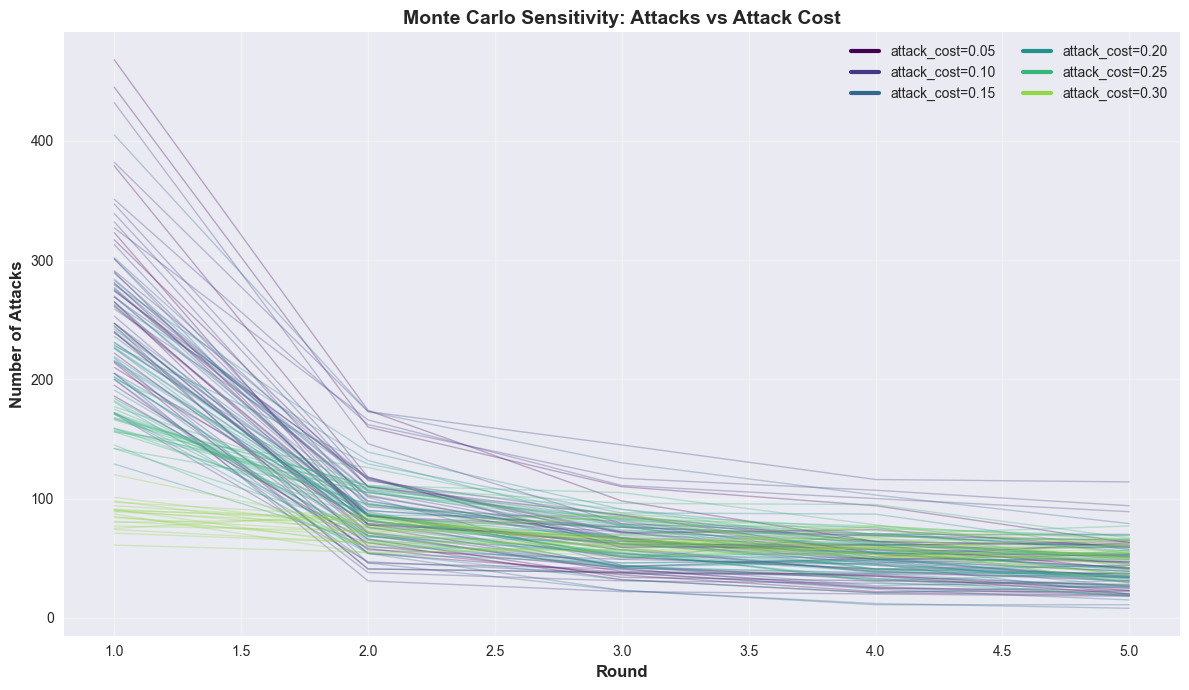

In [5]:
def plot_spaghetti(param_name='attack_cost', param_values=None, num_trials=20, num_rounds=5, num_countries=50):
    """
    Create spaghetti chart showing attacks over rounds for different parameter values.
    Each parameter value gets multiple MC trials plotted as separate lines.
    """
    if param_values is None:
        param_values = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    cmap = plt.get_cmap('viridis')
    
    for param_idx, param_val in enumerate(param_values):
        color = cmap(param_idx / len(param_values))
        
        # Run multiple trials for this parameter value
        for trial in range(num_trials):
            seed = trial + param_idx * 1000
            
            # Set parameters
            ds.NUM_COUNTRIES = num_countries
            ds.ATTACK_COST_PERCENTAGE = param_val if param_name == 'attack_cost' else ds.ATTACK_COST_PERCENTAGE
            ds.FAILED_ATTACK_COST_PERCENTAGE = param_val if param_name == 'failed_cost' else ds.FAILED_ATTACK_COST_PERCENTAGE
            ds.NUKE_PROBABILITY = param_val if param_name == 'nuke_prob' else ds.NUKE_PROBABILITY
            
            sim = ds.DeterrenceSimulation(num_countries=num_countries, seed=seed)
            
            attack_counts = []
            for _ in range(num_rounds):
                with contextlib.redirect_stdout(io.StringIO()):
                    results = sim.run_round()
                attacks_this_round = sum(1 for r in results if r['outcome'] in ['attack_success', 'defense_success'])
                attack_counts.append(attacks_this_round)
            
            rounds_plot = list(range(1, num_rounds + 1))
            ax.plot(rounds_plot, attack_counts, color=color, alpha=0.3, linewidth=1)
        
        # Plot mean line for this parameter value
        ax.plot([], [], color=color, linewidth=3, label=f'{param_name}={param_val:.2f}')
    
    ax.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Attacks', fontsize=12, fontweight='bold')
    ax.set_title(f'Monte Carlo Sensitivity: Attacks vs {param_name.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10, ncol=2)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example: vary attack cost
plot_spaghetti(param_name='attack_cost', param_values=[0.05, 0.10, 0.15, 0.20, 0.25, 0.30], 
               num_trials=20, num_rounds=5, num_countries=50)

